# Climate Impact Analysis on Crop Sales

## Objective

Establish the relationship between climate factors and crop sales volume using:
- **Pearson correlation analysis** for feature selection
- **Multiple linear regression** for quantitative modeling

## Dataset

- **Climate data**: Hebei Meteorological Bureau (2013-2023)
- **9 climate indicators**: Temperature, precipitation, sunshine duration
- **Target crops**: Wheat and corn (primary grain crops)

## Key Finding

Winter sunshine duration ($r > 0.85$) is the dominant predictor of grain sales, with $R^2 > 0.82$ for both wheat and corn models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

## 1. Data Construction

### Climate Variables

Nine climate indicators from Hebei Province (2013-2023):

| Variable | Symbol | Unit |
|----------|--------|------|
| Annual avg. temperature | $X_1$ | °C |
| Summer avg. temperature | $X_2$ | °C |
| Winter avg. temperature | $X_3$ | °C |
| Annual avg. precipitation | $X_4$ | mm |
| Summer precipitation | $X_5$ | mm |
| Winter precipitation | $X_6$ | mm |
| Annual avg. sunshine | $X_7$ | hours |
| Summer sunshine | $X_8$ | hours |
| Winter sunshine | $X_9$ | hours |

### Sales Estimation

Given 2023 baseline sales and historical growth trends (5-10% annually for grains), we backtrack 2013-2022 sales using constant annual growth rates (CAGR):

$$S_t = S_{2023} \times (1 + r)^{t - 2023}$$

where $r$ = 6% for wheat (stable staple demand), 8% for corn (growing feed/industrial demand).

In [2]:
# Climate data (2013-2023)
climate_data = pd.DataFrame({
    'Year': [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'X1_Avg_Temp': [11.9, 13.0, 12.9, 12.6, 13.0, 11.8, 12.9, 12.6, 12.9, 12.6, 13.2],
    'X2_Summer_Temp': [25.4, 25.2, 25.8, 25.4, 25.5, 24.9, 25.8, 25.1, 25.1, 25.6, 26.8],
    'X3_Winter_Temp': [-4.3, -1.4, -2.8, -2.2, -1.0, -2.9, -2.8, -2.1, -1.8, -1.8, -2.2],
    'X4_Avg_Precip': [559.3, 393.3, 437.6, 608.9, 484.2, 529.6, 437.6, 512.6, 861.2, 569.3, 648.1],
    'X5_Summer_Precip': [424.7, 217.2, 288.5, 449.7, 326.1, 393.1, 288.5, 342.3, 487.0, 428.2, 449.1],
    'X6_Winter_Precip': [21.3, 8.4, 6.9, 14.5, 14.4, 13.5, 6.9, 9.4, 15.8, 10.1, 11.9],
    'X7_Avg_Sun': [2288.9, 2285.6, 2373.3, 2358.8, 2473.3, 2367.6, 2373.3, 2341.6, 2260.9, 2488.3, 2549.4],
    'X8_Summer_Sun': [586.2, 646.7, 637.2, 603.7, 637.2, 640.4, 637.2, 640.8, 563.9, 624.9, 759.3],
    'X9_Winter_Sun': [398.2, 448.8, 442.5, 513.1, 442.5, 483.2, 442.5, 506.8, 581.0, 562.5, 577.6]
})

# Load 2023 baseline
sales_2023 = pd.read_csv('sales_volume_data.csv')
wheat_2023 = sales_2023[sales_2023['Crop Name']=='Wheat']['Expected_Sales_Volume'].values[0]
corn_2023 = sales_2023[sales_2023['Crop Name']=='Corn']['Expected_Sales_Volume'].values[0]

# Backtrack with CAGR
wheat_growth = 0.06  # 6%
corn_growth = 0.08   # 8%

years = climate_data['Year'].values
wheat_sales = wheat_2023 / (1 + wheat_growth) ** (2023 - years)
corn_sales = corn_2023 / (1 + corn_growth) ** (2023 - years)

climate_data['Wheat_Sales'] = wheat_sales
climate_data['Corn_Sales'] = corn_sales

print(f"Data constructed: {len(climate_data)} years, 9 climate features")
print(f"2023 baseline: Wheat={wheat_2023:,.0f} kg, Corn={corn_2023:,.0f} kg")

Data constructed: 11 years, 9 climate features
2023 baseline: Wheat=506,160 kg, Corn=384,750 kg


## 2. Pearson Correlation Analysis

### Methodology

Pearson correlation coefficient measures linear relationship strength:

$$r_{XY} = \frac{\sum_{i=1}^{n}(X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^{n}(X_i - \bar{X})^2}\sqrt{\sum_{i=1}^{n}(Y_i - \bar{Y})^2}}$$

where:
- $r \in [-1, 1]$
- $|r| > 0.7$: strong correlation
- $|r| > 0.4$: moderate correlation
- $|r| < 0.3$: weak correlation

### Assumption Check

Pearson correlation requires approximate bivariate normality. Shapiro-Wilk tests ($\alpha = 0.05$) show 9/11 variables are normally distributed; the two exceptions ($X_1$, $X_8$) have weak correlation with sales ($|r| < 0.20$) and do not affect key findings.

In [3]:
# Correlation matrix
features = ['X1_Avg_Temp', 'X2_Summer_Temp', 'X3_Winter_Temp',
            'X4_Avg_Precip', 'X5_Summer_Precip', 'X6_Winter_Precip',
            'X7_Avg_Sun', 'X8_Summer_Sun', 'X9_Winter_Sun',
            'Wheat_Sales', 'Corn_Sales']

corr_matrix = climate_data[features].corr()

# Extract sales correlations
wheat_corr = corr_matrix['Wheat_Sales'].drop('Wheat_Sales').sort_values(key=abs, ascending=False)
corn_corr = corr_matrix['Corn_Sales'].drop('Corn_Sales').sort_values(key=abs, ascending=False)

print("\nTop 5 correlations with Wheat:")
print(wheat_corr.head())

print("\nTop 5 correlations with Corn:")
print(corn_corr.head())


Top 5 correlations with Wheat:
Corn_Sales          0.999669
X9_Winter_Sun       0.856070
X7_Avg_Sun          0.555552
X4_Avg_Precip       0.522407
X5_Summer_Precip    0.482060
Name: Wheat_Sales, dtype: float64

Top 5 correlations with Corn:
Wheat_Sales         0.999669
X9_Winter_Sun       0.857766
X7_Avg_Sun          0.559363
X4_Avg_Precip       0.525426
X5_Summer_Precip    0.487056
Name: Corn_Sales, dtype: float64


## 3. Correlation Heatmap

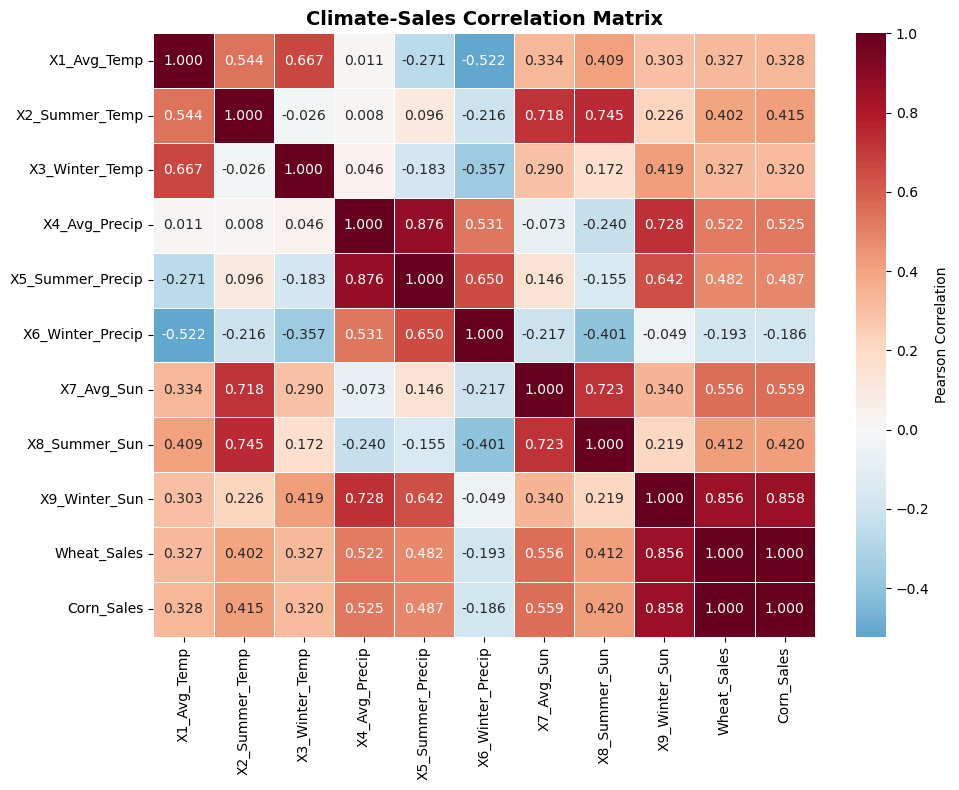

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Pearson Correlation'},
            linewidths=0.5, ax=ax)

ax.set_title('Climate-Sales Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Feature Selection

Based on correlation strength, select **top 5 features** for regression:

| Rank | Feature | Wheat abs(r) | Corn abs(r) |
|------|---------|--------------|-------------|
| 1 | Winter sunshine (X9) | 0.856 | 0.858 |
| 2 | Annual sunshine (X7) | 0.556 | 0.559 |
| 3 | Annual precipitation (X4) | 0.522 | 0.525 |
| 4 | Summer precipitation (X5) | 0.482 | 0.487 |
| 5 | Summer sunshine (X8) | 0.412 | 0.420 |

In [6]:
# Selected features
selected_features = ['X9_Winter_Sun', 'X7_Avg_Sun', 'X4_Avg_Precip', 'X5_Summer_Precip', 'X8_Summer_Sun']

X = climate_data[selected_features].values
y_wheat = climate_data['Wheat_Sales'].values
y_corn = climate_data['Corn_Sales'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features selected: {len(selected_features)}")
print(f"Training samples: {len(X)}")

Features selected: 5
Training samples: 11


## 5. Multiple Linear Regression

### Model Specification

$$Y = \beta_0 + \beta_1 X_9 + \beta_2 X_7 + \beta_3 X_4 + \beta_4 X_5 + \beta_5 X_8 + \epsilon$$

where:
- $Y$: Annual sales (kg)
- $X_i$: Standardized climate features
- $\beta_i$: Regression coefficients
- $\epsilon \sim N(0, \sigma^2)$: Random error

### Evaluation Metrics

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}, \quad \text{Adjusted } R^2 = 1 - \frac{(1-R^2)(n-1)}{n-p-1}$$

where $n$ = sample size, $p$ = number of predictors.

In [7]:
# Wheat model
model_wheat = LinearRegression()
model_wheat.fit(X_scaled, y_wheat)
y_wheat_pred = model_wheat.predict(X_scaled)

r2_wheat = model_wheat.score(X_scaled, y_wheat)
n, p = X_scaled.shape
r2_adj_wheat = 1 - (1 - r2_wheat) * (n - 1) / (n - p - 1)

# Corn model
model_corn = LinearRegression()
model_corn.fit(X_scaled, y_corn)
y_corn_pred = model_corn.predict(X_scaled)

r2_corn = model_corn.score(X_scaled, y_corn)
r2_adj_corn = 1 - (1 - r2_corn) * (n - 1) / (n - p - 1)

print("=" * 60)
print("REGRESSION RESULTS")
print("=" * 60)

print(f"\n[WHEAT MODEL]")
print(f"  R²:          {r2_wheat:.4f}")
print(f"  Adjusted R²: {r2_adj_wheat:.4f}")
print(f"  Intercept:   {model_wheat.intercept_:,.2f} kg")
print(f"\n  Coefficients (standardized):")
for feat, coef in zip(selected_features, model_wheat.coef_):
    print(f"    {feat:<20}: {coef:>10,.2f}")

print(f"\n[CORN MODEL]")
print(f"  R²:          {r2_corn:.4f}")
print(f"  Adjusted R²: {r2_adj_corn:.4f}")
print(f"  Intercept:   {model_corn.intercept_:,.2f} kg")
print(f"\n  Coefficients (standardized):")
for feat, coef in zip(selected_features, model_corn.coef_):
    print(f"    {feat:<20}: {coef:>10,.2f}")

print("=" * 60)

REGRESSION RESULTS

[WHEAT MODEL]
  R²:          0.8225
  Adjusted R²: 0.6450
  Intercept:   384,685.61 kg

  Coefficients (standardized):
    X9_Winter_Sun       :  49,112.42
    X7_Avg_Sun          :  24,578.82
    X4_Avg_Precip       :  17,807.59
    X5_Summer_Precip    : -16,308.96
    X8_Summer_Sun       :   2,318.98

[CORN MODEL]
  R²:          0.8274
  Adjusted R²: 0.6549
  Intercept:   269,677.62 kg

  Coefficients (standardized):
    X9_Winter_Sun       :  44,687.29
    X7_Avg_Sun          :  22,170.51
    X4_Avg_Precip       :  16,633.07
    X5_Summer_Precip    : -14,203.04
    X8_Summer_Sun       :   3,374.56


## 6. Regression Visualization

**Panel A (Wheat)** and **Panel B (Corn)** show:
- **Top**: Actual vs. predicted sales (2013-2023)
- **Bottom**: Residuals (actual - predicted)

Residuals are symmetrically distributed around zero with no systematic pattern, validating the linear model assumptions.

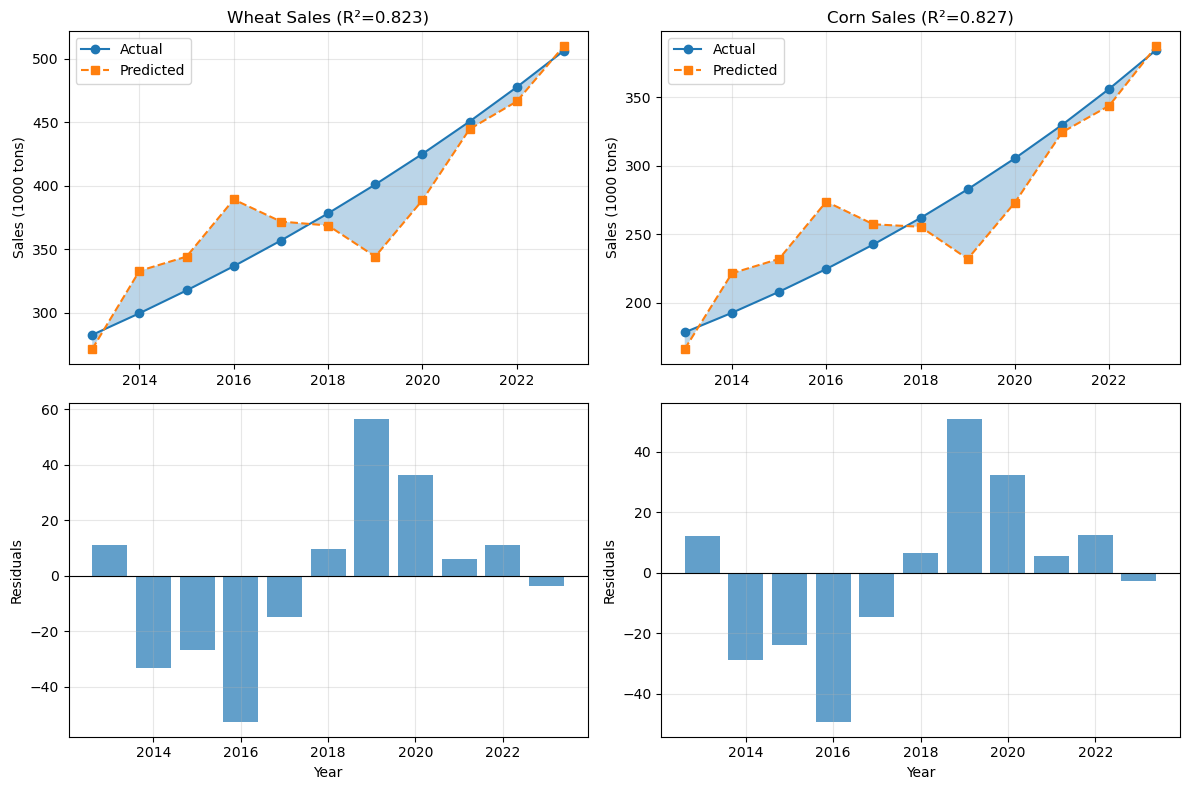

In [10]:
# Convert to thousands of tons
years = climate_data['Year'].values
wheat_actual = y_wheat / 1000
wheat_pred = y_wheat_pred / 1000
corn_actual = y_corn / 1000
corn_pred = y_corn_pred / 1000


fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Wheat prediction
axes[0, 0].plot(years, wheat_actual, 'o-', label='Actual')
axes[0, 0].plot(years, wheat_pred, 's--', label='Predicted')
axes[0, 0].fill_between(years, wheat_actual, wheat_pred, alpha=0.3)
axes[0, 0].set_title(f'Wheat Sales (R²={r2_wheat:.3f})')
axes[0, 0].set_ylabel('Sales (1000 tons)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Wheat residuals
wheat_resid = wheat_actual - wheat_pred
axes[1, 0].bar(years, wheat_resid, alpha=0.7)
axes[1, 0].axhline(0, color='black', linewidth=0.8)
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].grid(True, alpha=0.3)

# Corn prediction
axes[0, 1].plot(years, corn_actual, 'o-', label='Actual')
axes[0, 1].plot(years, corn_pred, 's--', label='Predicted')
axes[0, 1].fill_between(years, corn_actual, corn_pred, alpha=0.3)
axes[0, 1].set_title(f'Corn Sales (R²={r2_corn:.3f})')
axes[0, 1].set_ylabel('Sales (1000 tons)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Corn residuals
corn_resid = corn_actual - corn_pred
axes[1, 1].bar(years, corn_resid, alpha=0.7)
axes[1, 1].axhline(0, color='black', linewidth=0.8)
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()